Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Batches: 100%|██████████| 3123/3123 [20:35<00:00,  2.53it/s]


Epoch 1 - Training Metrics:
Accuracy: 0.8570
Precision: 0.7562
Recall: 0.5327
F1 Score: 0.6125


Validation Batches: 100%|██████████| 544/544 [01:09<00:00,  7.87it/s]


Epoch 1 - Validation Metrics:
Accuracy: 0.8691
Precision: 0.6991
Recall: 0.6724
F1 Score: 0.6736


Training Batches: 100%|██████████| 3123/3123 [20:33<00:00,  2.53it/s]


Epoch 2 - Training Metrics:
Accuracy: 0.8820
Precision: 0.7998
Recall: 0.6277
F1 Score: 0.6934


Validation Batches: 100%|██████████| 544/544 [01:08<00:00,  7.95it/s]


Epoch 2 - Validation Metrics:
Accuracy: 0.8721
Precision: 0.7138
Recall: 0.6785
F1 Score: 0.6826


Training Batches: 100%|██████████| 3123/3123 [20:29<00:00,  2.54it/s]


Epoch 3 - Training Metrics:
Accuracy: 0.8934
Precision: 0.8225
Recall: 0.6621
F1 Score: 0.7245


Validation Batches: 100%|██████████| 544/544 [01:08<00:00,  7.91it/s]


Epoch 3 - Validation Metrics:
Accuracy: 0.8753
Precision: 0.7200
Recall: 0.6772
F1 Score: 0.6858


Training Batches: 100%|██████████| 3123/3123 [20:29<00:00,  2.54it/s]


Epoch 4 - Training Metrics:
Accuracy: 0.8991
Precision: 0.8390
Recall: 0.6730
F1 Score: 0.7378


Validation Batches: 100%|██████████| 544/544 [01:08<00:00,  7.94it/s]


Epoch 4 - Validation Metrics:
Accuracy: 0.8753
Precision: 0.7200
Recall: 0.6772
F1 Score: 0.6858


Training Batches: 100%|██████████| 3123/3123 [20:28<00:00,  2.54it/s]


Epoch 5 - Training Metrics:
Accuracy: 0.8991
Precision: 0.8380
Recall: 0.6747
F1 Score: 0.7387


Validation Batches: 100%|██████████| 544/544 [01:08<00:00,  7.96it/s]


Epoch 5 - Validation Metrics:
Accuracy: 0.8753
Precision: 0.7200
Recall: 0.6772
F1 Score: 0.6858


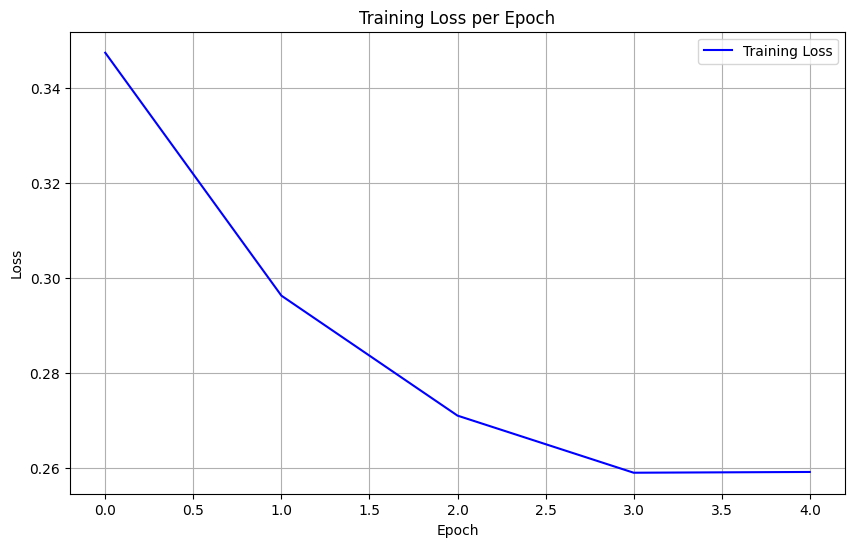

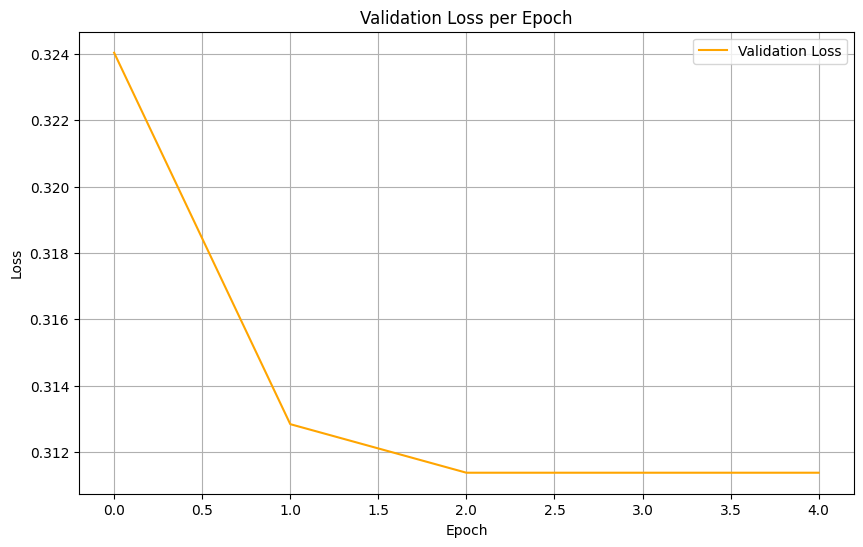

Section 1 - Overall Metrics:
Accuracy: 0.8753
Precision: 0.7200
Recall: 0.6772
F1 Score: 0.6858
ROC AUC: 0.8833


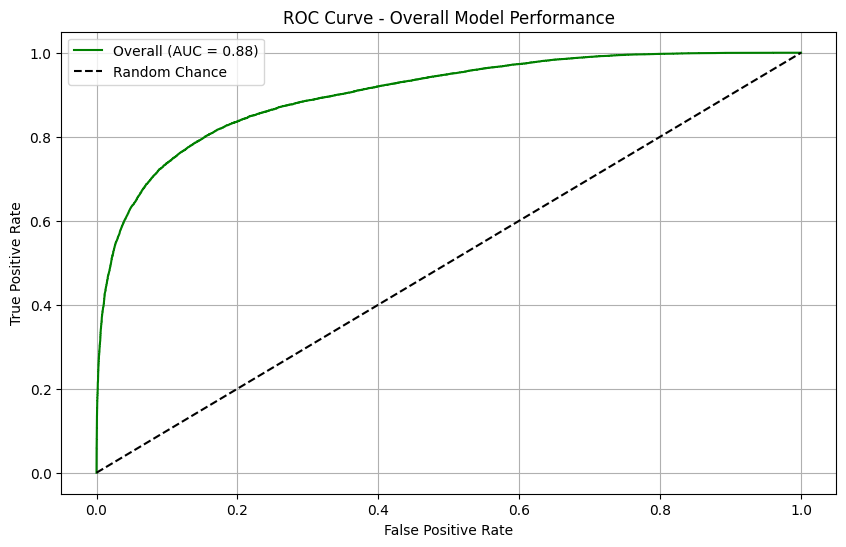

Section 2 - Per-Class Metrics:
                 Precision    Recall  F1 Score
toxicity          0.642428  0.922797  0.757502
severe_toxicity   0.566809  0.354067  0.435864
obscene           0.787062  0.720276  0.752190
threat            0.702479  0.518926  0.596910
insult            0.780719  0.904348  0.837998
identity_attack   0.765932  0.760947  0.763431
sexual_explicit   0.794776  0.559055  0.656394


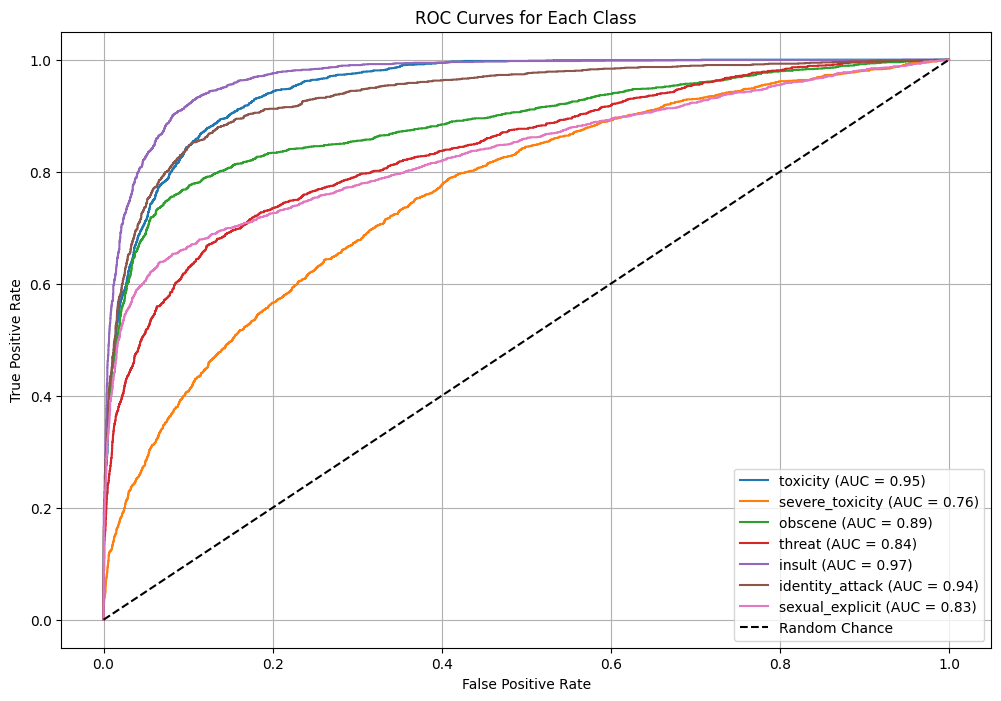

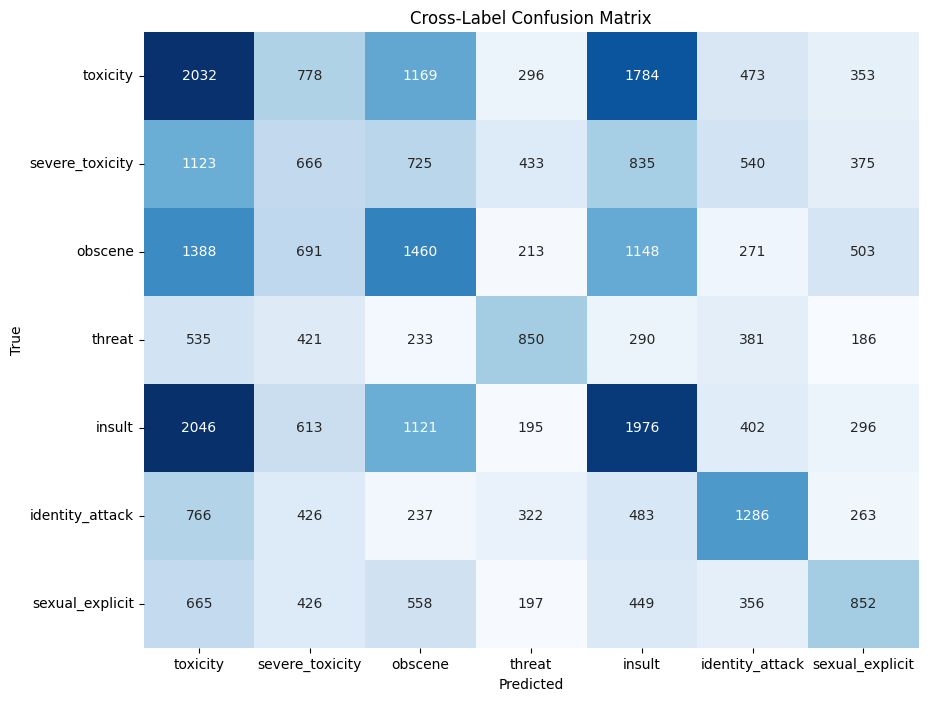

Section 3 - Strict Test Metrics:
Exact Match Accuracy: 0.4773
Hamming Loss: 0.1247
Jaccard Score: 0.6448


In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW, get_scheduler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from datasets import load_dataset
from sklearn.utils import resample
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import logging

# Configuration
label_columns = ['toxicity', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']
thresholds = {
    'toxicity': 0.6000,
    'severe_toxicity': 0.0435,
    'obscene': 0.1042,
    'threat': 0.0878,
    'insult': 0.5000,
    'identity_attack': 0.1667,
    'sexual_explicit': 0.0189
}
data_paths = {
    'train': 'train_balanced.csv',
    'validation': 'val_balanced.csv',
    'test': 'test_balanced.csv'
}

# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, label_columns, max_length=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.label_columns = label_columns
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']
        labels = torch.tensor(row[self.label_columns].astype(float).to_numpy(), dtype=torch.float32)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': labels
        }

def binarize_labels(dataframe, thresholds):
    for label, threshold in thresholds.items():
        dataframe[label] = pd.to_numeric(dataframe[label], errors='coerce').fillna(0)
        dataframe[label] = (dataframe[label] > threshold).astype(int)
    return dataframe

def create_balanced_dataset(dataframe, label_columns, min_samples_per_class=5000, negative_sample_ratio=0.5):
    dataframe[label_columns] = dataframe[label_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)
    balanced_df = []

    for label in label_columns:
        positive_samples = dataframe[dataframe[label] == 1]
        if len(positive_samples) < min_samples_per_class:
            positive_samples = resample(
                positive_samples,
                replace=True,
                n_samples=min_samples_per_class,
                random_state=42
            )
        else:
            positive_samples = positive_samples.sample(n=min_samples_per_class, random_state=42)
        balanced_df.append(positive_samples)

    balanced_df = pd.concat(balanced_df).drop_duplicates()

    negative_samples = dataframe[dataframe[label_columns].sum(axis=1) == 0]
    num_negative_samples = int(len(balanced_df) * negative_sample_ratio)
    if len(negative_samples) < num_negative_samples:
        negative_samples = resample(
            negative_samples,
            replace=True,
            n_samples=num_negative_samples,
            random_state=42
        )
    else:
        negative_samples = negative_samples.sample(n=num_negative_samples, random_state=42)

    balanced_df = pd.concat([balanced_df, negative_samples]).drop_duplicates()
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

def prepare_datasets():
    dataset = load_dataset("google/civil_comments")

    train_df = dataset['train'].to_pandas()
    val_df = dataset['validation'].to_pandas()
    test_df = dataset['test'].to_pandas()

    train_df = binarize_labels(train_df, thresholds)
    val_df = binarize_labels(val_df, thresholds)
    test_df = binarize_labels(test_df, thresholds)

    train_balanced = create_balanced_dataset(train_df, label_columns)
    val_balanced = create_balanced_dataset(val_df, label_columns, min_samples_per_class=1000)
    test_balanced = create_balanced_dataset(test_df, label_columns, min_samples_per_class=1000)

    train_balanced.to_csv(data_paths['train'], index=False)
    val_balanced.to_csv(data_paths['validation'], index=False)
    test_balanced.to_csv(data_paths['test'], index=False)
    logging.info("Balanced datasets saved.")

def calculate_metrics(preds, labels, threshold=0.5):
    binarized_preds = (preds >= threshold).astype(int)
    binarized_labels = labels.astype(int)

    overall_accuracy = accuracy_score(binarized_labels.flatten(), binarized_preds.flatten())
    precision, recall, f1, _ = precision_recall_fscore_support(binarized_labels, binarized_preds, average='macro')
    overall_roc_auc = roc_auc_score(binarized_labels, preds, average='macro')

    class_metrics = precision_recall_fscore_support(binarized_labels, binarized_preds, average=None)

    return {
        'overall': {
            'accuracy': overall_accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': overall_roc_auc
        },
        'per_class': {
            'precision': class_metrics[0],
            'recall': class_metrics[1],
            'f1': class_metrics[2],
        }
    }

# Rest of the main code continues unchanged...
def exact_match_metrics(y_true, y_pred):
    correct = 0
    total = len(y_true)
    hamming_losses = []
    jaccard_scores = []

    for true_labels, pred_labels in zip(y_true, y_pred):
        true_set = set(np.where(true_labels == 1)[0])
        pred_set = set(np.where(pred_labels >= 0.5)[0])

        if true_set == pred_set:
            correct += 1

        hamming_losses.append(len(true_set.symmetric_difference(pred_set)) / len(y_true[0]))
        if true_set or pred_set:
            jaccard_scores.append(len(true_set.intersection(pred_set)) / len(true_set.union(pred_set)))
        else:
            jaccard_scores.append(1.0)

    exact_match_accuracy = correct / total
    avg_hamming_loss = np.mean(hamming_losses)
    avg_jaccard_score = np.mean(jaccard_scores)

    return {
        'exact_match_accuracy': exact_match_accuracy,
        'hamming_loss': avg_hamming_loss,
        'jaccard_score': avg_jaccard_score
    }

def plot_section1(metrics, train_losses, val_losses, all_labels, all_preds):
    # Plot training losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print("Section 1 - Overall Metrics:")
    print(f"Accuracy: {metrics['overall']['accuracy']:.4f}")
    print(f"Precision: {metrics['overall']['precision']:.4f}")
    print(f"Recall: {metrics['overall']['recall']:.4f}")
    print(f"F1 Score: {metrics['overall']['f1']:.4f}")
    print(f"ROC AUC: {metrics['overall']['roc_auc']:.4f}")

    # Plot ROC Curve for overall model performance
    plt.figure(figsize=(10, 6))
    y_true_flat = all_labels.flatten()
    y_score_flat = all_preds.flatten()
    fpr, tpr, _ = roc_curve(y_true_flat, y_score_flat)
    plt.plot(fpr, tpr, label=f'Overall (AUC = {metrics["overall"]["roc_auc"]:.2f})', color='green')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.title('ROC Curve - Overall Model Performance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

def plot_section2(metrics, all_preds, all_labels, label_columns):
    # Plot per-class metrics
    metrics_df = pd.DataFrame({
        'Precision': metrics['per_class']['precision'],
        'Recall': metrics['per_class']['recall'],
        'F1 Score': metrics['per_class']['f1']
    }, index=label_columns)
    print("Section 2 - Per-Class Metrics:")
    print(metrics_df)

    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(label_columns):
        fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
        auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
        plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.title('ROC Curves for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid()
    plt.show()

    # Cross-label confusion matrix
    cross_label_matrix = np.zeros((len(label_columns), len(label_columns)), dtype=int)
    for i in range(len(label_columns)):
        for j in range(len(label_columns)):
            cross_label_matrix[i, j] = np.sum((all_labels[:, i] == 1) & (all_preds[:, j] >= 0.5))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cross_label_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_columns, yticklabels=label_columns, cbar=False)
    plt.title("Cross-Label Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def plot_section3(all_labels, all_preds):
    metrics = exact_match_metrics(all_labels, all_preds)
    print("Section 3 - Strict Test Metrics:")
    print(f"Exact Match Accuracy: {metrics['exact_match_accuracy']:.4f}")
    print(f"Hamming Loss: {metrics['hamming_loss']:.4f}")
    print(f"Jaccard Score: {metrics['jaccard_score']:.4f}")

def train_and_test_model():
    logging.info("Preparing datasets...")
    train_df = pd.read_csv(data_paths['train'])
    val_df = pd.read_csv(data_paths['validation'])
    #train_df = pd.read_csv(data_paths['train']).iloc[:100]  # First 100 rows
    #val_df = pd.read_csv(data_paths['validation']).iloc[:50]  # First 50 rows

    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    model = RobertaForSequenceClassification.from_pretrained(
        "roberta-base",
        num_labels=len(label_columns),
        problem_type="multi_label_classification"
    )
    device = get_device()
    model.to(device)

    train_dataset = MultiLabelDataset(train_df, tokenizer, label_columns)
    val_dataset = MultiLabelDataset(val_df, tokenizer, label_columns)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    num_training_steps = len(train_loader) * 3
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    num_epochs = 5
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        logging.info(f"Starting epoch {epoch + 1}/{num_epochs}...")
        model.train()
        train_loss = 0
        all_preds_train, all_labels_train = [], []

        for batch in tqdm(train_loader, desc="Training Batches"):
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                labels=batch['labels']
            )

            loss = outputs.loss
            train_loss += loss.item()

            logits = outputs.logits
            all_preds_train.append(torch.sigmoid(logits).detach().cpu().numpy())
            all_labels_train.append(batch['labels'].cpu().numpy())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        train_losses.append(train_loss / len(train_loader))

        all_preds_train = np.vstack(all_preds_train)
        all_labels_train = np.vstack(all_labels_train)
        train_metrics = calculate_metrics(all_preds_train, all_labels_train)
        print(f"Epoch {epoch + 1} - Training Metrics:")
        print(f"Accuracy: {train_metrics['overall']['accuracy']:.4f}")
        print(f"Precision: {train_metrics['overall']['precision']:.4f}")
        print(f"Recall: {train_metrics['overall']['recall']:.4f}")
        print(f"F1 Score: {train_metrics['overall']['f1']:.4f}")

        model.eval()
        val_loss = 0
        all_preds_val, all_labels_val = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation Batches"):
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                val_loss += outputs.loss.item()

                logits = outputs.logits
                all_preds_val.append(torch.sigmoid(logits).cpu().numpy())
                all_labels_val.append(batch['labels'].cpu().numpy())

        val_losses.append(val_loss / len(val_loader))

        all_preds_val = np.vstack(all_preds_val)
        all_labels_val = np.vstack(all_labels_val)
        val_metrics = calculate_metrics(all_preds_val, all_labels_val)
        print(f"Epoch {epoch + 1} - Validation Metrics:")
        print(f"Accuracy: {val_metrics['overall']['accuracy']:.4f}")
        print(f"Precision: {val_metrics['overall']['precision']:.4f}")
        print(f"Recall: {val_metrics['overall']['recall']:.4f}")
        print(f"F1 Score: {val_metrics['overall']['f1']:.4f}")

    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            logits = outputs.logits
            all_preds.append(torch.sigmoid(logits).cpu().numpy())
            all_labels.append(batch['labels'].cpu().numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    metrics = calculate_metrics(all_preds, all_labels)

    plot_section1(metrics, train_losses, val_losses, all_labels, all_preds)
    plot_section2(metrics, all_preds, all_labels, label_columns)
    plot_section3(all_labels, all_preds)

if __name__ == "__main__":
    prepare_datasets()
    
    train_and_test_model()
